In [40]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 1 

In [1]:
import numpy as np
import pandas as pd

In [89]:
class LogisticRegression(object):
    
    default_tol = 1e-8  # solver tol
    _exp_lim = 40  # exp overflow range

    def __init__(self, tol=default_tol,
                 random_state=None):
        self.tol = tol
        if random_state is not None:
            np.random.seed(random_state)
        
    def fit(self, X, y):
        X_train = self.transform(X, fit=True)
        y_train = np.array(y)
        self.n_params = len(X_train[0])  # include intercept
        self.beta = self.newton_optimize(X_train, y_train)
    
    def exp_ybx(self, X_train, y_train, beta):
        return np.exp(- y_train * np.sum(beta * X_train, axis=1))
    
    def loss(self, X_train, y_train, beta):
        return np.sum(1 + self.exp_ybx(X_train, y_train, beta))
        
    def newton_optimize(self, X_train, y_train):
        beta, start, J = np.zeros(self.n_params), True, None
        print(beta)
        while True:
            H, dJ = [], []
            w = self.exp_ybx(X_train, y_train, beta) / (1 + self.exp_ybx(X_train, y_train, beta))
            for i in range(self.n_params):
                dJi = np.sum(w * (-y_train * X_train[:, i]))
                Hi = []
                for j in range(self.n_params):
                    Hij = np.sum((w - w**2) * X_train[:, i] * X_train[:, j])
                    Hi.append(Hij)
                H.append(Hi)
                dJ.append(dJi)
            H, dJ = np.array(H), np.array(dJ)
            H_1 = self.matrix_inverse(H)
            beta -= np.dot(H_1, dJ)
            print(beta)
            curr_J = self.loss(X_train, y_train, beta)
            if not start:
                if J - curr_J < self.tol:
                    break
            else:
                start = False
            J = curr_J
        return beta
    
    def matrix_inverse(self, H):
        if len(H) == 3:
            return self.matrix_inverse_3d(H)
        return np.linalg.inv(H)
    
    def matrix_inverse_3d(self, H):
        det = H[0, 0] * H[1, 1] * H[2, 2] + H[0, 1] * H[1, 2] * H[2, 0] + H[1, 0] * H[2, 1] * H[0, 2]
        det -= H[0, 2] * H[1, 1] * H[2, 0] + H[0, 1] * H[1, 0] * H[2, 2] + H[0, 0] * H[1, 2] * H[2, 1]
        other = {0: (1, 2), 1: (0, 2), 2: (0, 1)}
        H_1 = []
        for i in other:
            H_1_i = []
            for j in other:
                H_1_i.append((H[other[i][0], other[j][0]] * H[other[i][1], other[j][1]] -
                             H[other[i][1], other[j][0]] * H[other[i][0], other[j][1]]) *
                             (-1) ** (i + j))
            H_1.append(H_1_i)
        H_1 = np.array(H_1)
        return H_1 / det

    def transform(self, X, fit=True, standardize=False):
        X = np.array(X)
        if standardize:
            if fit:
                self.X_mean = X.mean(axis=0)
                self.X_std = X.std(axis=0)
                if 0. in self.X_std:
                    raise ZeroDivisionError('Please remove the column with identical values')
            X = (X - self.X_mean) / self.X_std
        return np.hstack([np.ones(len(X)).reshape(len(X), 1), X])

In [90]:
X_train = pd.read_fwf('logistic_x.txt', header=None, names=['x1', 'x2'])
y_train = pd.read_fwf('logistic_y.txt', header=None, names=['y'])

In [91]:
lr = LogisticRegression()
lr.fit(X_train.values, y_train.y.values)

[0. 0. 0.]
[-1.50983811  0.43509696  0.62161752]
[-2.21834632  0.64372727  0.95944716]


In [92]:
lr.beta

array([-2.21834632,  0.64372727,  0.95944716])

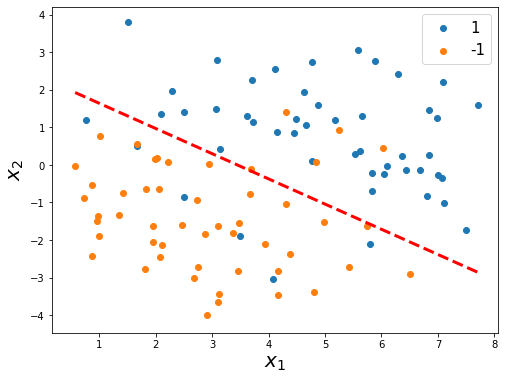

In [93]:
figure(figsize=(8, 6))
scatter(X_train[y_train.y == 1]['x1'], X_train[y_train.y == 1]['x2'], label='1')
scatter(X_train[y_train.y == -1]['x1'], X_train[y_train.y == -1]['x2'], label='-1')
legend(fontsize=15)
plot(np.array([X_train.x1.min(), X_train.x1.max()]),
     [-(lr.beta[0] + lr.beta[1] * x) / lr.beta[2] for x in np.array([X_train.x1.min(), X_train.x1.max()])],
    linewidth=3, color='r', linestyle='--')
xlabel(r'$x_1$', size=20)
ylabel(r'$x_2$', size=20)
show()